In [1]:
import os
os.chdir('D:\Birkbeck\MSc Data Science\Project\Data sets\Selected datasets')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Input, Dropout
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#attempt to create reproducible results in NN
from numpy.random import seed
seed(3)
from tensorflow import random
random.set_seed(3)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('precision',3)

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Import training file created in EDA.
train_data = pd.read_csv('la_train_data.csv')
train_data = train_data.drop(columns = 'Unnamed: 0')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3425 entries, 0 to 3424
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   la_code                 3425 non-null   object 
 1   la_name                 3425 non-null   object 
 2   year                    3425 non-null   int64  
 3   g_belt_area             3425 non-null   int64  
 4   total_area              3425 non-null   int64  
 5   rpi                     3425 non-null   float64
 6   int_rate_max            3425 non-null   float64
 7   int_rate_min            3425 non-null   float64
 8   median_income           3425 non-null   int64  
 9   population              3425 non-null   int64  
 10  num_hh_1dp              3425 non-null   float64
 11  num_hh_>2dp             3425 non-null   float64
 12  num_hh_2dp              3425 non-null   float64
 13  num_hh_1f               3425 non-null   float64
 14  num_hh_1m               3425 non-null   

In [4]:
#Import test file created in EDA.
test_data = pd.read_csv('la_test_data.csv')
test_data = test_data.drop(columns = 'Unnamed: 0')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   la_code                 859 non-null    object 
 1   la_name                 859 non-null    object 
 2   year                    859 non-null    int64  
 3   g_belt_area             859 non-null    int64  
 4   total_area              859 non-null    int64  
 5   rpi                     859 non-null    float64
 6   int_rate_max            859 non-null    float64
 7   int_rate_min            859 non-null    float64
 8   median_income           859 non-null    int64  
 9   population              859 non-null    int64  
 10  num_hh_1dp              859 non-null    float64
 11  num_hh_>2dp             859 non-null    float64
 12  num_hh_2dp              859 non-null    float64
 13  num_hh_1f               859 non-null    float64
 14  num_hh_1m               859 non-null    fl

In [5]:
# for easier reference, change the scale of all_sls_price - target to be in thousands
# i.e. 196000 becomes 196.0
train_data['all_sls_price'] = train_data['all_sls_price']/1000
train_data['all_sls_price'].describe()

count    3425.000
mean      191.115
std        80.238
min        38.250
25%       133.000
50%       175.000
75%       230.000
max       598.000
Name: all_sls_price, dtype: float64

In [6]:
test_data['all_sls_price'] = test_data['all_sls_price']/1000
test_data['all_sls_price'].describe()

count    859.000
mean     191.819
std       82.628
min       36.000
25%      132.363
50%      171.950
75%      235.000
max      577.500
Name: all_sls_price, dtype: float64

In [7]:
# need a validation set for training a NN.
# exclude la_code & la_name - wont scale

X = train_data.iloc[ : , 2:43]
y = train_data.iloc[ : , -1]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 3)
X_train.shape, y_train.shape, X_valid.shape

((2740, 41), (2740,), (685, 41))

In [8]:
#scale the data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)

X_valid = scaler.transform(X_valid)

## NN Base Model for Comparison
- untuned model
- 1 hidden layer

In [9]:
nn_model_a = Sequential()
nn_model_a.add(Dense(41, input_dim = 41, activation = 'relu'))
nn_model_a.add(Dense(20, activation = 'relu'))
nn_model_a.add(Dense(1))


nn_model_a.compile(loss="mae", optimizer="adam", metrics = 'mse')
history_a = nn_model_a.fit(X_train, y_train, 
                       epochs=500, 
                       batch_size = 32,
                       validation_data=(X_valid, y_valid),
                       callbacks = [EarlyStopping(patience = 20)])

Epoch 1/500
86/86 [==============================] - 2s 13ms/step - loss: 185.8526 - mse: 41135.6641 - val_loss: 178.2161 - val_mse: 37716.9219
Epoch 2/500
86/86 [==============================] - 1s 10ms/step - loss: 138.6192 - mse: 26500.5176 - val_loss: 86.1659 - val_mse: 12378.4121
Epoch 3/500
86/86 [==============================] - 1s 10ms/step - loss: 68.3822 - mse: 8314.2227 - val_loss: 59.7035 - val_mse: 6304.0269
Epoch 4/500
86/86 [==============================] - 1s 10ms/step - loss: 61.3857 - mse: 6618.1045 - val_loss: 55.9249 - val_mse: 5390.7017
Epoch 5/500
86/86 [==============================] - 1s 10ms/step - loss: 57.5174 - mse: 5748.8936 - val_loss: 52.5519 - val_mse: 4833.0513
Epoch 6/500
86/86 [==============================] - 1s 10ms/step - loss: 53.1086 - mse: 4973.1206 - val_loss: 48.6137 - val_mse: 4183.4717
Epoch 7/500
86/86 [==============================] - 1s 10ms/step - loss: 47.9782 - mse: 4182.6436 - val_loss: 44.2803 - val_mse: 3573.7642
Epoch 8/500
8

In [10]:
nn_model_a.evaluate(X_valid, y_valid)

22/22 [==============================] - 0s 5ms/step - loss: 15.5623 - mse: 473.2964


[15.562335968017578, 473.29638671875]

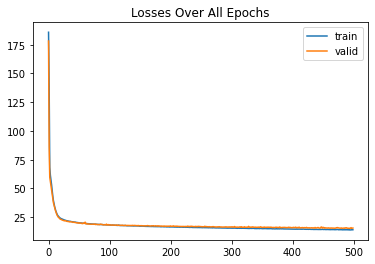

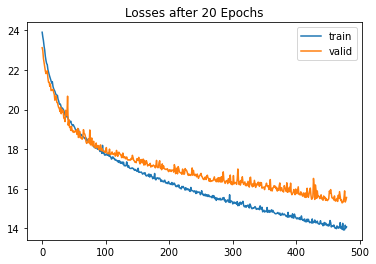

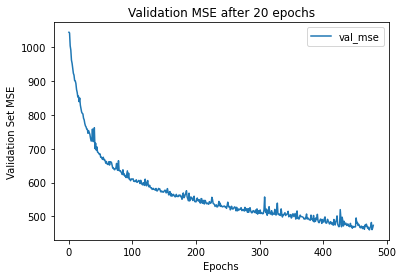

(None, None, None)

In [11]:
def plots_output(model_history):
    plt_one = plt.plot(model_history.history['loss'],label = 'train')
    plt_one = plt.plot(model_history.history['val_loss'], label = 'valid')
    plt_one = plt.legend()
    plt_one = plt.title('Losses Over All Epochs')
    plt_one = plt.show()  
                       
    plt_two = plt.plot(model_history.history['loss'][20:],label = 'train')
    plt_two = plt.plot(model_history.history['val_loss'][20:], label = 'valid')
    plt_two = plt.legend()
    plt_two = plt.title('Losses after 20 Epochs')
    plt_two = plt.show()    
                       
    plt_three = plt.plot(model_history.history['val_mse'][20:], label = 'val_mse')
    plt_three = plt.xlabel('Epochs')
    plt_three = plt.ylabel('Validation Set MSE')
    plt_three = plt.legend()
    plt_three = plt.title('Validation MSE after 20 epochs')
    plt_three = plt.show()  
                       
    return plt_one, plt_two, plt_three
                       
plots_output(history_a)

In [12]:
nn_model_a.save('D:\Birkbeck\MSc Data Science\Project\Data sets\Code',save_format='tf')

INFO:tensorflow:Assets written to: D:\Birkbeck\MSc Data Science\Project\Data sets\Code\assets


In [13]:
#save the weights for reproducibility:
nn_weights_a = nn_model_a.get_weights()

with open('nn_weights_a.out','ab') as f:
    for item in nn_weights_a:
        np.savetxt(f, item, delimiter = ',')

### Set up the test set

In [14]:
X_test = test_data.iloc[ : , 2:43]
y_test = test_data.iloc[ : , -1]

#normalise the data
X_test = scaler.transform(X_test)

In [15]:
#apply to NN
score_a = nn_model_a.evaluate(X_test, y_test)
score_a

27/27 [==============================] - 0s 5ms/step - loss: 15.3923 - mse: 535.1774


[15.392277717590332, 535.1773681640625]

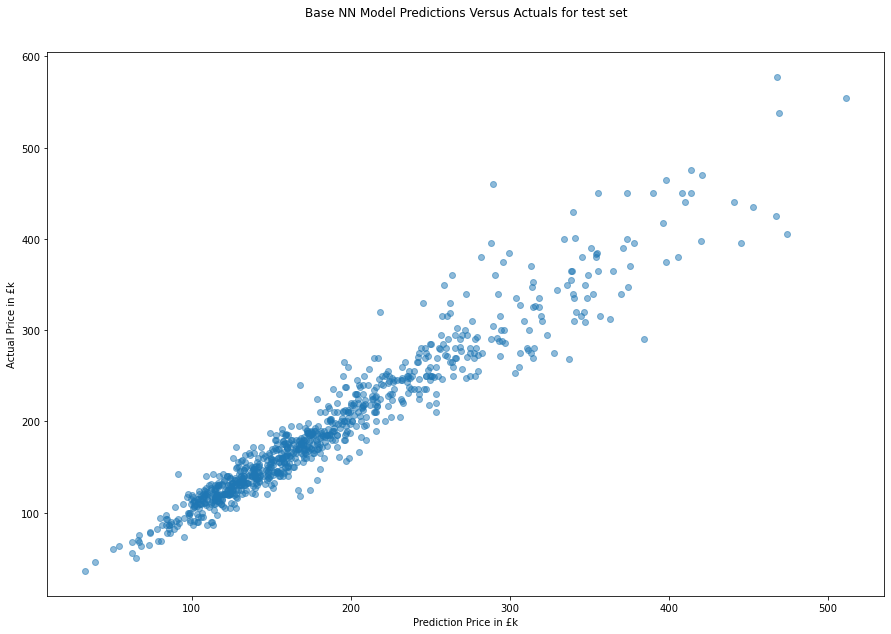

In [16]:
def test_data_plot(model, X, y, model_ref):
    plt.figure(figsize=(15,10))
    plt.scatter(model.predict(X), y.values, alpha = 0.5)
    plt.xlabel('Prediction Price in £k')
    plt.ylabel('Actual Price in £k')
    plt.title(model_ref + 'Predictions Versus Actuals for test set\n\n')
    return plt.show()

test_data_plot(nn_model_a, X_test,y_test,'Base NN Model ')


In [17]:
def model_perf(model, X, y):
  
    ref = 'diffs_'+str(model)
    #Create Df for output
    model_pred = model.predict(X)
    ref = pd.DataFrame(model_pred,y).reset_index()
    ref.columns = ['actual','pred']
    ref['diff'] = abs(ref['pred']-ref['actual'])
    ref['percent_diff'] = ref['diff']/ref['actual']*100
    
    r2 = r2_score(y,model_pred)
    mae = mean_absolute_error(y,model_pred)
    mse = mean_squared_error(y,model_pred)
    rmse = np.sqrt(mse)
    diff_tot = ref['diff'].sum()
    act_tot = y.sum()
    mean_abs_percent_error = diff_tot/act_tot*100
    
    med_act = ref['actual'].median()
    med_pred = round(ref['pred'].median(),3)
    print()
    print('%s: %.2f%%' % ('R2:', r2))
    print('MSE: ',round(mse,3))
    print('MAE: ',round(mae,3))
    print('RMSE: ',round(rmse,3)) 
  
    print('%s: %.2f%%' % ('Percentage difference:', round(( mean_abs_percent_error),3)))
    print('Max £ difference: ',round(abs(ref['diff'].max()),3))
    print()
    print('Median £ difference: ',round(abs(ref['diff'].median()),3))
    print('Median actual price:', med_act,' Median pedicted price:', med_pred)
  
    print()
    print('Number of predictions over 10% wrong: ',ref['percent_diff'][ref['percent_diff'] > 10].count(),'out of ',len(ref['pred']))
    print('Number of predictions 10% wrong pr less: ',ref['percent_diff'][ref['percent_diff'] <= 10].count(),'out of ',len(ref['pred']))
    
    
    return ref

model_perf(nn_model_a,X_test,y_test)


R2:: 0.92%
MSE:  535.177
MAE:  15.392
RMSE:  23.134
Percentage difference:: 8.02%
Max £ difference:  170.437

Median £ difference:  10.581
Median actual price: 171.95  Median pedicted price: 167.374

Number of predictions over 10% wrong:  235 out of  859
Number of predictions 10% wrong pr less:  624 out of  859


,actual,pred,diff,percent_diff
0,163.500,170.195,6.695,4.095
1,118.000,107.755,10.245,8.683
2,160.000,149.559,10.441,6.526
3,397.500,420.086,22.586,5.682
4,125.000,129.168,4.168,3.334
5,176.000,168.437,7.563,4.297
6,150.000,158.775,8.775,5.850
7,325.000,318.483,6.517,2.005
8,185.000,184.721,0.279,0.151
9,179.950,196.645,16.695,9.278


## Can generalisation be improved?
 - particularly on the outliers
 - tune the model

In [18]:
def model_tune(n_hidden=1, n_neurons=41, input_shape = [41]):
    model = Sequential()
    model.add(InputLayer(input_shape = input_shape))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss = 'mae', optimizer = 'adam', metrics = 'mse')
    return model

#call the function to create the model
nn_model_b = KerasRegressor(model_tune, verbose = 0)

#search parameters
params = {'n_hidden' : [4,5,6,7,8,9,10],
          'n_neurons' : np.arange(1,100)}

r_search = RandomizedSearchCV(nn_model_b, params, verbose=1, cv=5, random_state = 3)
r_search.fit(X_train, y_train,
                       validation_data = (X_valid, y_valid), 
                       callbacks = [EarlyStopping(patience = 10)])
print(r_search.best_params_)
print(r_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_neurons': 88, 'n_hidden': 5}
-57.11553268432617


In [19]:
nn_model_b = r_search.best_estimator_.model
history_b = nn_model_b.fit(X_train, y_train, 
                       epochs=500, 
                       batch_size = 32,
                       validation_data=(X_valid, y_valid),
                       callbacks = [EarlyStopping(patience = 20)])
                           

Epoch 1/500
86/86 [==============================] - 1s 13ms/step - loss: 41.3798 - mse: 3227.9592 - val_loss: 31.5979 - val_mse: 1729.6161
Epoch 2/500
86/86 [==============================] - 1s 12ms/step - loss: 26.4439 - mse: 1380.3013 - val_loss: 23.1756 - val_mse: 1032.5045
Epoch 3/500
86/86 [==============================] - 1s 12ms/step - loss: 23.3481 - mse: 1078.7762 - val_loss: 23.0965 - val_mse: 990.6686
Epoch 4/500
86/86 [==============================] - 1s 12ms/step - loss: 21.9907 - mse: 959.5262 - val_loss: 20.7732 - val_mse: 817.0128
Epoch 5/500
86/86 [==============================] - 1s 12ms/step - loss: 21.1733 - mse: 891.1245 - val_loss: 21.9186 - val_mse: 920.2637
Epoch 6/500
86/86 [==============================] - 1s 12ms/step - loss: 20.1853 - mse: 831.0594 - val_loss: 20.0533 - val_mse: 751.3195
Epoch 7/500
86/86 [==============================] - 1s 12ms/step - loss: 19.9124 - mse: 815.0400 - val_loss: 20.4515 - val_mse: 759.2549
Epoch 8/500
86/86 [==========

In [20]:
nn_model_b.evaluate(X_valid, y_valid)

22/22 [==============================] - 0s 6ms/step - loss: 13.6283 - mse: 363.7714


[13.62826156616211, 363.7713928222656]

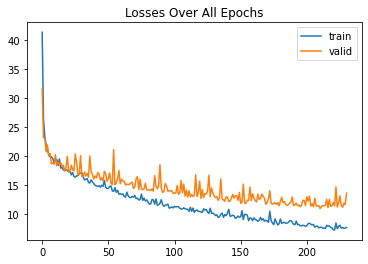

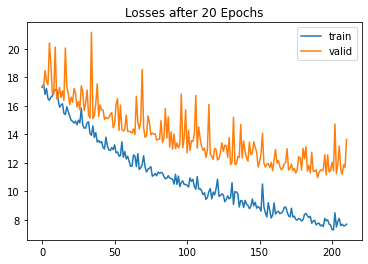

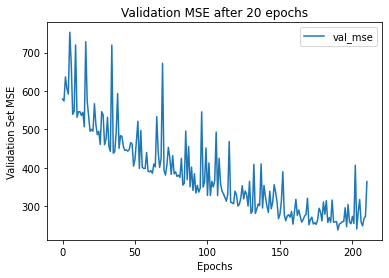

(None, None, None)

In [21]:
plots_output(history_b)

In [22]:
score_b = nn_model_b.evaluate(X_test, y_test)
score_b

27/27 [==============================] - 0s 7ms/step - loss: 12.6410 - mse: 384.3455


[12.640978813171387, 384.345458984375]

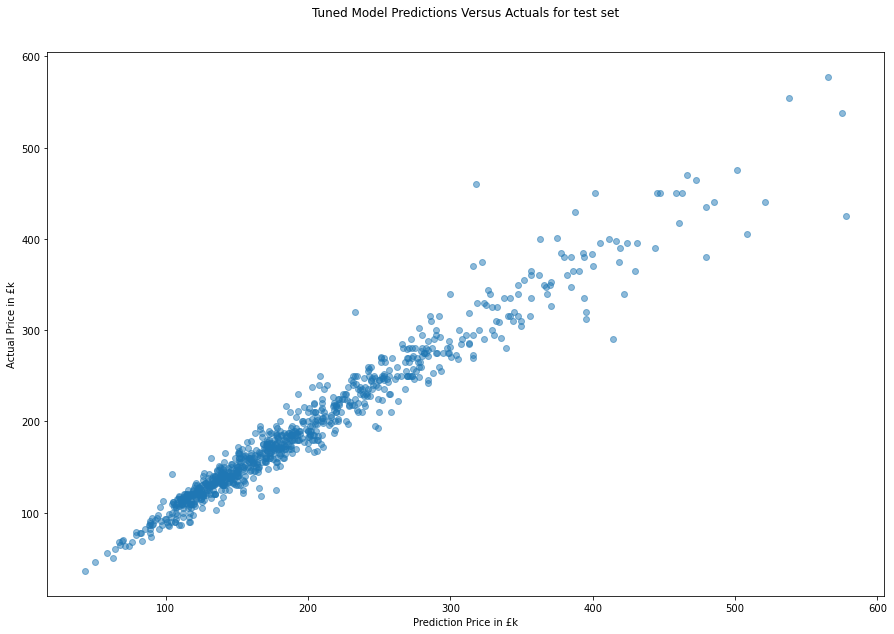

In [23]:
test_data_plot(nn_model_b, X_test,y_test,'Tuned Model ')

In [24]:
model_perf(nn_model_b,X_test,y_test)


R2:: 0.94%
MSE:  384.345
MAE:  12.641
RMSE:  19.605
Percentage difference:: 6.59%
Max £ difference:  153.18

Median £ difference:  8.294
Median actual price: 171.95  Median pedicted price: 176.223

Number of predictions over 10% wrong:  178 out of  859
Number of predictions 10% wrong pr less:  681 out of  859


,actual,pred,diff,percent_diff
0,163.500,166.408,2.908e+00,1.778e+00
1,118.000,126.044,8.044e+00,6.817e+00
2,160.000,183.146,2.315e+01,1.447e+01
3,397.500,416.684,1.918e+01,4.826e+00
4,125.000,125.140,1.396e-01,1.117e-01
5,176.000,174.896,1.104e+00,6.270e-01
6,150.000,140.852,9.148e+00,6.099e+00
7,325.000,329.494,4.494e+00,1.383e+00
8,185.000,188.483,3.483e+00,1.883e+00
9,179.950,189.097,9.147e+00,5.083e+00


In [42]:
mod_b_df = pd.DataFrame(model_perf(nn_model_b, X_test, y_test))
mod_b_df.to_csv('model_b_output.csv')


R2:: 0.94%
MSE:  384.345
MAE:  12.641
RMSE:  19.605
Percentage difference:: 6.59%
Max £ difference:  153.18

Median £ difference:  8.294
Median actual price: 171.95  Median pedicted price: 176.223

Number of predictions over 10% wrong:  178 out of  859
Number of predictions 10% wrong pr less:  681 out of  859



### With 2 hidden layers:

Is there any improvement some where between the 1 hidden layer model and the tuned model?

In [25]:
# To increase complexity but not overfit. 
nn_model_c = Sequential()
nn_model_c.add(Dense(41, input_dim = 41, activation = 'relu'))
nn_model_c.add(Dense(20, activation = 'relu'))
nn_model_c.add(Dense(20, activation = 'relu'))
nn_model_c.add(Dense(1))

nn_model_c.compile(loss="mae", optimizer="adam", metrics = 'mse')
history_c = nn_model_c.fit(X_train, y_train, 
                       epochs=500, 
                       batch_size = 32,
                       validation_data=(X_valid, y_valid),
                       callbacks = [EarlyStopping(patience = 20)])

Epoch 1/500
86/86 [==============================] - 2s 13ms/step - loss: 182.3182 - mse: 39890.2930 - val_loss: 156.0885 - val_mse: 30247.8809
Epoch 2/500
86/86 [==============================] - 1s 10ms/step - loss: 85.4167 - mse: 12346.4482 - val_loss: 58.6906 - val_mse: 5970.6001
Epoch 3/500
86/86 [==============================] - 1s 10ms/step - loss: 58.1587 - mse: 5812.0210 - val_loss: 51.2211 - val_mse: 4469.8662
Epoch 4/500
86/86 [==============================] - 1s 10ms/step - loss: 48.4090 - mse: 4145.6943 - val_loss: 43.0459 - val_mse: 2953.8198
Epoch 5/500
86/86 [==============================] - 1s 10ms/step - loss: 38.9879 - mse: 2815.1970 - val_loss: 35.8243 - val_mse: 2259.4504
Epoch 6/500
86/86 [==============================] - 1s 10ms/step - loss: 32.7550 - mse: 2085.8406 - val_loss: 31.7250 - val_mse: 1726.3954
Epoch 7/500
86/86 [==============================] - 1s 10ms/step - loss: 29.1100 - mse: 1672.7422 - val_loss: 27.8627 - val_mse: 1444.2056
Epoch 8/500
86/

In [26]:
nn_model_c.evaluate(X_valid, y_valid)

22/22 [==============================] - 0s 5ms/step - loss: 15.8215 - mse: 495.2786


[15.821479797363281, 495.2785949707031]

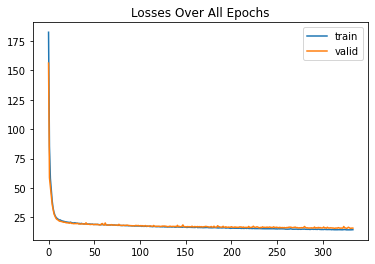

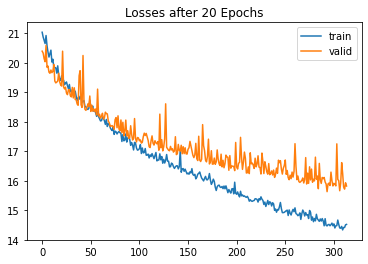

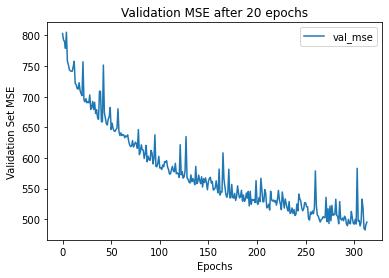

(None, None, None)

In [27]:
plots_output(history_c)

In [28]:
score_c = nn_model_c.evaluate(X_test, y_test)
score_c

27/27 [==============================] - 0s 5ms/step - loss: 15.4619 - mse: 520.2212


[15.461886405944824, 520.22119140625]

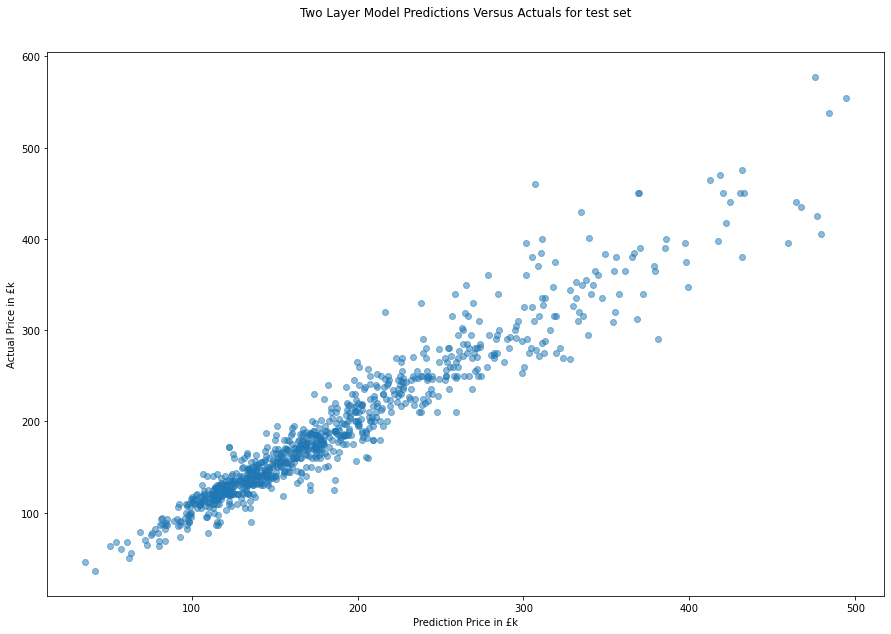

In [29]:
test_data_plot(nn_model_c,X_test,y_test,'Two Layer Model ')

In [30]:
model_perf(nn_model_c, X_test,y_test)


R2:: 0.92%
MSE:  520.221
MAE:  15.462
RMSE:  22.808
Percentage difference:: 8.06%
Max £ difference:  152.984

Median £ difference:  10.711
Median actual price: 171.95  Median pedicted price: 169.377

Number of predictions over 10% wrong:  245 out of  859
Number of predictions 10% wrong pr less:  614 out of  859


,actual,pred,diff,percent_diff
0,163.500,176.803,13.303,8.137
1,118.000,112.627,5.373,4.553
2,160.000,151.361,8.639,5.399
3,397.500,416.982,19.482,4.901
4,125.000,124.435,0.565,0.452
5,176.000,179.273,3.273,1.860
6,150.000,146.645,3.355,2.237
7,325.000,300.279,24.721,7.607
8,185.000,176.362,8.638,4.669
9,179.950,209.162,29.212,16.233


## PCA On the Dataset

In [31]:
pca = PCA(n_components = 0.98, random_state = 3)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
print("Number of principle components that explain 95% of the variance: ",len(pca.explained_variance_))

Number of principle components that explain 95% of the variance:  20


In [32]:
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

In [41]:
# Use the orginal model a structure as a baseline:
nn_model_pca = Sequential()
nn_model_pca.add(Dense(20, input_dim = 20, activation = 'relu'))
nn_model_pca.add(Dense(10, activation = 'relu'))
nn_model_pca.add(Dense(1))
nn_model_pca.compile(loss="mae", optimizer="adam", metrics = 'mse')
history_pca = nn_model_pca.fit(X_train_pca, y_train, 
                       epochs=1000, 
                       batch_size = 32,
                       validation_data=(X_valid_pca, y_valid),
                       callbacks = [EarlyStopping(patience = 20)])


Epoch 1/1000
86/86 [==============================] - 2s 14ms/step - loss: 190.1302 - mse: 42725.9727 - val_loss: 191.9225 - val_mse: 42805.0352
Epoch 2/1000
86/86 [==============================] - 1s 11ms/step - loss: 187.6431 - mse: 41827.0000 - val_loss: 187.5417 - val_mse: 41190.2930
Epoch 3/1000
86/86 [==============================] - 1s 11ms/step - loss: 179.6790 - mse: 38969.4805 - val_loss: 174.9745 - val_mse: 36677.4961
Epoch 4/1000
86/86 [==============================] - 1s 11ms/step - loss: 160.5053 - mse: 32489.4707 - val_loss: 148.2531 - val_mse: 28059.0195
Epoch 5/1000
86/86 [==============================] - 1s 12ms/step - loss: 125.0462 - mse: 22382.8867 - val_loss: 104.0854 - val_mse: 16507.6738
Epoch 6/1000
86/86 [==============================] - 1s 10ms/step - loss: 78.2978 - mse: 11593.5186 - val_loss: 60.1337 - val_mse: 7225.8042
Epoch 7/1000
86/86 [==============================] - 1s 10ms/step - loss: 50.2730 - mse: 5478.5586 - val_loss: 42.8377 - val_mse: 36

In [34]:
nn_model_pca.evaluate(X_valid_pca, y_valid)

22/22 [==============================] - 0s 4ms/step - loss: 18.7383 - mse: 706.0916


[18.73826789855957, 706.0916137695312]

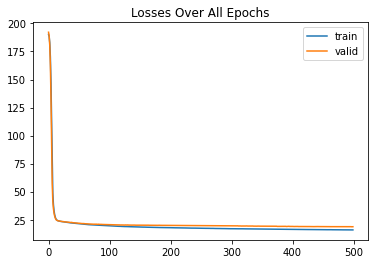

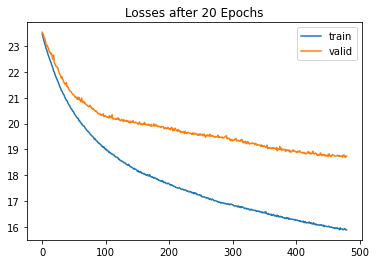

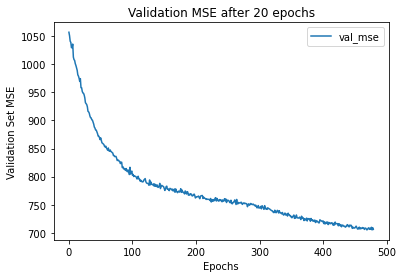

(None, None, None)

In [35]:
plots_output(history_pca)  

In [36]:
score_pca = nn_model_pca.evaluate(X_test_pca, y_test)
score_pca

27/27 [==============================] - 0s 5ms/step - loss: 17.8006 - mse: 698.1053


[17.800569534301758, 698.1053466796875]

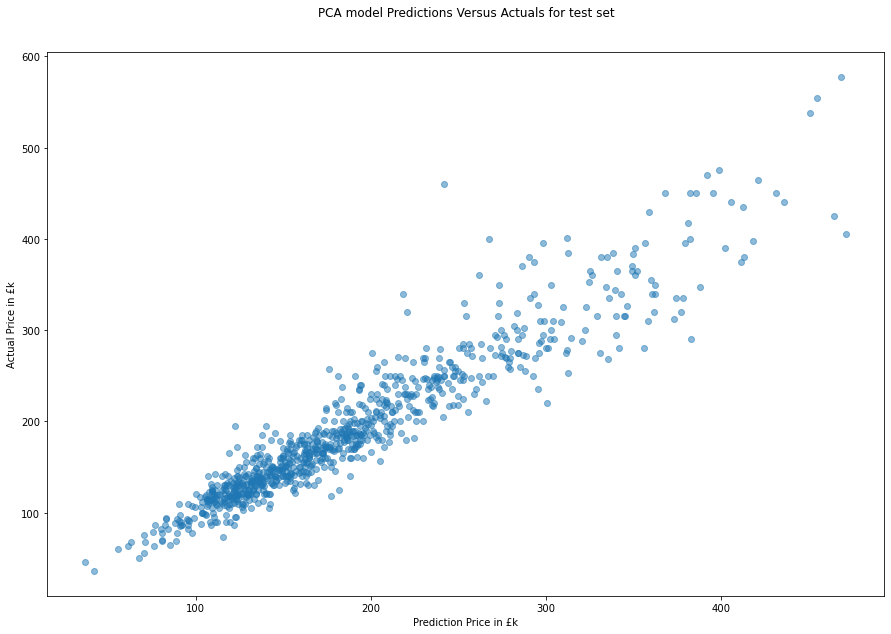

In [37]:
test_data_plot(nn_model_pca, X_test_pca, y_test, 'PCA model ')

In [38]:
model_perf(nn_model_pca, X_test_pca, y_test)


R2:: 0.90%
MSE:  698.105
MAE:  17.801
RMSE:  26.422
Percentage difference:: 9.28%
Max £ difference:  218.314

Median £ difference:  12.074
Median actual price: 171.95  Median pedicted price: 171.873

Number of predictions over 10% wrong:  298 out of  859
Number of predictions 10% wrong pr less:  561 out of  859


,actual,pred,diff,percent_diff
0,163.500,161.647,1.853,1.133
1,118.000,109.825,8.175,6.928
2,160.000,147.926,12.074,7.546
3,397.500,418.659,21.159,5.323
4,125.000,128.157,3.157,2.525
5,176.000,180.354,4.354,2.474
6,150.000,143.891,6.109,4.073
7,325.000,309.881,15.119,4.652
8,185.000,185.775,0.775,0.419
9,179.950,204.199,24.249,13.475


In [39]:
nn_model_pca.save('D:\Birkbeck\MSc Data Science\Project\Data sets\Code',save_format='tf')

INFO:tensorflow:Assets written to: D:\Birkbeck\MSc Data Science\Project\Data sets\Code\assets


In [40]:
#save the weights for reproducibility:
nn_weights_pca = nn_model_pca.get_weights()

with open('nn_weights_pca.out','ab') as f:
    for item in nn_weights_pca:
        np.savetxt(f, item, delimiter = ',')

### Using a smaller dataset:
- Data contains many features that were created as composite features of others, so there is some dependence in the data.
- Features Selected Using Kbest ANOVA and Mutual Information

In [73]:
# refer to best from EDA, net_additions added as a feature of importance to the project
best_lst = ['total_area',
 'pop_density_avail',
 'prop_semi_sls',
 'median_income',
 'gdp_hh',
 'prop_flat_sls',
 'prop_hh_1_person',
 'avail_land',
 'year',
 'rpi',
 'num_wait_lst',
 'ratio_new_exist_prices',
 'prop_det_sls',
 'aff_rent',
 'aff_sh_own',
 'population',
 'avg_hh_size',
 'num_hh_2dp',
 'num_hh_oth',
 'int_rate_max',
 'dwell_stock',
 'prop_terr_sls',
 'net_add_to_hh',
 'g_belt_percent',
 'num_hh_1dp',
 'num_hh_1m',
 'wait_list_to_hh',
 'pop_density',
 'int_rate_min',
 'num_hh_>2dp',
 'net_additions',
'all_sls_price',]

data_best = pd.DataFrame(train_data, columns = best_lst)
test_best = pd.DataFrame(test_data, columns = best_lst)
data_best.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3425 entries, 0 to 3424
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_area              3425 non-null   int64  
 1   pop_density_avail       3425 non-null   float64
 2   prop_semi_sls           3425 non-null   float64
 3   median_income           3425 non-null   int64  
 4   gdp_hh                  3425 non-null   float64
 5   prop_flat_sls           3425 non-null   float64
 6   prop_hh_1_person        3425 non-null   float64
 7   avail_land              3425 non-null   float64
 8   year                    3425 non-null   int64  
 9   rpi                     3425 non-null   float64
 10  num_wait_lst            3425 non-null   float64
 11  ratio_new_exist_prices  3425 non-null   float64
 12  prop_det_sls            3425 non-null   float64
 13  aff_rent                3425 non-null   float64
 14  aff_sh_own              3425 non-null   

In [74]:
# save data files for further use
data_best.to_csv('train_best.csv')
test_best.to_csv('test_best.csv')

In [44]:
# need a validation set for training a NN.
X_b = data_best.iloc[ : , 0:31]
y_b = data_best.iloc[ : , -1]

X_train_b, X_valid_b, y_train_b, y_valid_b = train_test_split(X_b,y_b, test_size = 0.2, random_state = 3)
X_train_b.shape, y_train_b.shape, X_valid_b.shape, y_valid_b.shape

((2740, 31), (2740,), (685, 31), (685,))

In [45]:
# scale again:
best_scaled = MinMaxScaler()
best_scaled.fit(X_train_b)
X_train_b = best_scaled.transform(X_train_b)

X_valid_b =  best_scaled.transform(X_valid_b)


In [46]:
nn_model_e = Sequential()
nn_model_e.add(Dense(31, input_dim = 31, activation = 'relu'))
nn_model_e.add(Dense(15, activation = 'relu'))
nn_model_e.add(Dense(1))


nn_model_e.compile(loss="mae", optimizer="adam", metrics = 'mse')
history_e = nn_model_e.fit(X_train_b, y_train_b, 
                       epochs=500, 
                       batch_size = 10,
                       validation_data=(X_valid_b, y_valid_b),
                       callbacks = [EarlyStopping(patience = 20)])

Epoch 1/500
274/274 [==============================] - 3s 8ms/step - loss: 141.4563 - mse: 28189.0957 - val_loss: 60.0519 - val_mse: 6466.8730
Epoch 2/500
274/274 [==============================] - 2s 7ms/step - loss: 58.3825 - mse: 5924.0723 - val_loss: 51.8539 - val_mse: 4793.3066
Epoch 3/500
274/274 [==============================] - 2s 7ms/step - loss: 49.5154 - mse: 4418.9604 - val_loss: 43.0230 - val_mse: 3363.5198
Epoch 4/500
274/274 [==============================] - 2s 7ms/step - loss: 40.2772 - mse: 3079.5259 - val_loss: 37.3026 - val_mse: 2329.9043
Epoch 5/500
274/274 [==============================] - 2s 7ms/step - loss: 34.9095 - mse: 2344.4858 - val_loss: 33.0186 - val_mse: 2000.8990
Epoch 6/500
274/274 [==============================] - 2s 7ms/step - loss: 31.8365 - mse: 1981.2936 - val_loss: 30.7069 - val_mse: 1660.3408
Epoch 7/500
274/274 [==============================] - 2s 7ms/step - loss: 29.9044 - mse: 1735.3376 - val_loss: 28.6495 - val_mse: 1509.8733
Epoch 8/500

In [47]:
nn_model_e.evaluate(X_valid_b, y_valid_b)

22/22 [==============================] - 0s 5ms/step - loss: 16.3029 - mse: 514.2866


[16.302854537963867, 514.28662109375]

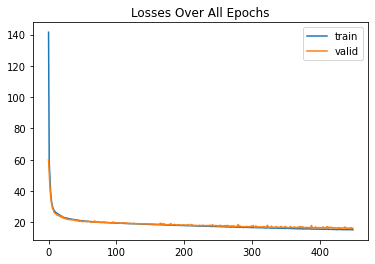

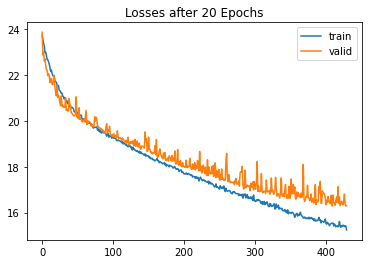

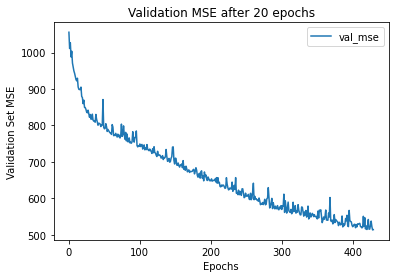

(None, None, None)

In [48]:
plots_output(history_e)

In [49]:
#on Test set...
X_test_b = test_best.iloc[ : , 0:31]
y_test_b = test_best.iloc[ : , -1]

X_test_b = best_scaled.transform(X_test_b)

score_e = nn_model_e.evaluate(X_test_b, y_test_b)
score_e

27/27 [==============================] - 0s 5ms/step - loss: 16.2427 - mse: 587.4592


[16.242748260498047, 587.459228515625]

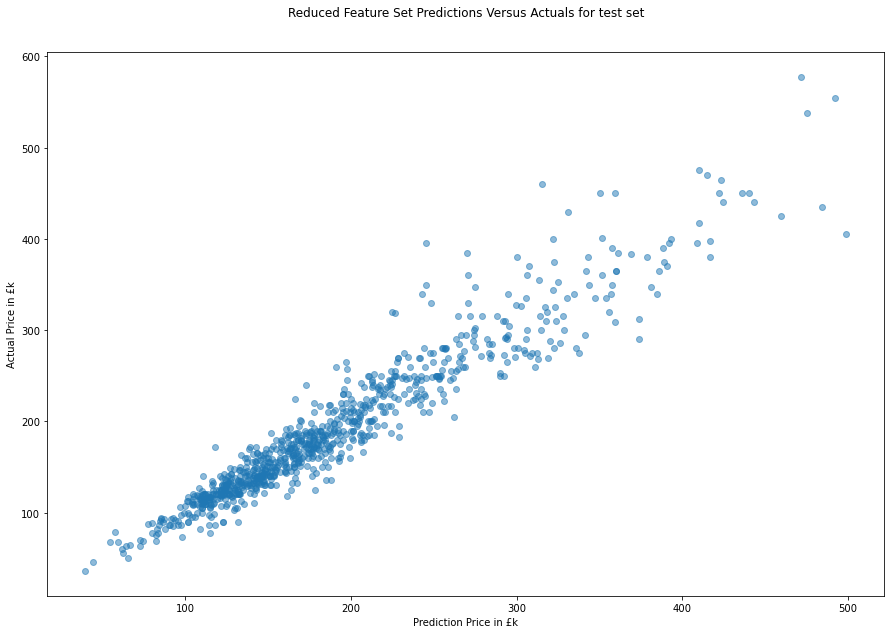

In [50]:
test_data_plot(nn_model_e, X_test_b, y_test_b, 'Reduced Feature Set ')

In [51]:
mod_e_df = pd.DataFrame(model_perf(nn_model_e, X_test_b, y_test_b))
mod_e_df.to_csv('model_e_output.csv')


R2:: 0.91%
MSE:  587.459
MAE:  16.243
RMSE:  24.238
Percentage difference:: 8.47%
Max £ difference:  149.449

Median £ difference:  10.942
Median actual price: 171.95  Median pedicted price: 171.822

Number of predictions over 10% wrong:  263 out of  859
Number of predictions 10% wrong pr less:  596 out of  859


In [52]:
nn_model_e.save('D:\Birkbeck\MSc Data Science\Project\Data sets\Code',save_format='tf')

INFO:tensorflow:Assets written to: D:\Birkbeck\MSc Data Science\Project\Data sets\Code\assets


In [53]:
#save the weights for reproducibility:
nn_weights_e = nn_model_e.get_weights()

with open('nn_weights_e.out','ab') as f:
    for item in nn_weights_e:
        np.savetxt(f, item, delimiter = ',')

### Outputs on  Dummy set

- Dummy sets have net additions volume doubled or halved to actual, all other features the same
- Tried on model_e first, then on model_a as best model

In [54]:
dummy_double = pd.read_csv('dummy_test.csv')
dummy_double = dummy_double.rename(columns = {'Unnamed: 0': 'ref'})
dummy_double = dummy_double.set_index('ref')
dummy_double.head(10)

,total_area,pop_density_avail,prop_semi_sls,median_income,gdp_hh,prop_flat_sls,prop_hh_1_person,avail_land,year,rpi,num_wait_lst,ratio_new_exist_prices,prop_det_sls,aff_rent,aff_sh_own,population,avg_hh_size,num_hh_2dp,num_hh_oth,int_rate_max,dwell_stock,prop_terr_sls,net_add_to_hh,g_belt_percent,num_hh_1dp,num_hh_1m,wait_list_to_hh,pop_density,int_rate_min,num_hh_>2dp,net_additions,all_sls_price
ref,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
368,503220,0.691,0.280,25177,0.042,0.087,0.309,0.913,2016,263.1,8367,1.378,0.330,170,6,317444,2.249,12997.587,62700.447,0.25,8476,0.303,0.007,0.087,17130.250,19345.717,0.059,0.631,0.25,4739.871,1982,157.500
438,11560,45.772,0.222,26354,0.085,0.411,0.369,0.889,2007,206.6,18196,1.246,0.034,0,0,470538,2.440,18118.836,66974.966,5.75,34914,0.333,0.025,0.111,24242.282,37635.492,0.094,40.704,5.25,12281.124,9802,139.995
529,61170,2.480,0.285,27896,0.068,0.169,0.282,1.000,2017,272.5,2466,1.057,0.278,52,6,151677,2.379,7424.906,27299.723,0.50,4,0.268,0.005,0.000,8385.345,8117.288,0.039,2.480,0.50,2675.100,582,265.000
556,6360,39.674,0.216,30310,0.078,0.325,0.276,0.368,2006,198.1,2203,1.110,0.236,0,0,92838,2.491,4875.013,15489.505,5.00,3416,0.223,0.014,0.632,4658.619,4519.928,0.059,14.597,4.75,1972.557,1016,235.000
602,5740,34.071,0.198,31997,0.077,0.411,0.325,0.977,2013,250.1,4415,0.843,0.069,19,0,191138,2.372,10133.854,30387.364,0.50,0,0.321,0.006,0.023,10444.948,11933.987,0.055,33.299,0.50,3394.743,970,460.000
711,9630,32.571,0.251,31022,0.075,0.224,0.278,0.417,2010,223.6,1716,1.104,0.331,0,0,130937,2.486,7806.773,20868.371,0.50,7,0.194,0.003,0.583,6717.907,5982.628,0.033,13.597,0.50,2623.205,364,395.000


In [55]:
dummy_double.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 368 to 711
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_area              6 non-null      int64  
 1   pop_density_avail       6 non-null      float64
 2   prop_semi_sls           6 non-null      float64
 3   median_income           6 non-null      int64  
 4   gdp_hh                  6 non-null      float64
 5   prop_flat_sls           6 non-null      float64
 6   prop_hh_1_person        6 non-null      float64
 7   avail_land              6 non-null      float64
 8   year                    6 non-null      int64  
 9   rpi                     6 non-null      float64
 10  num_wait_lst            6 non-null      int64  
 11  ratio_new_exist_prices  6 non-null      float64
 12  prop_det_sls            6 non-null      float64
 13  aff_rent                6 non-null      int64  
 14  aff_sh_own              6 non-null      in

In [56]:
#Split target and scale
X_dummy_d = dummy_double.iloc[ : , 0:31]
y_dummy_d = dummy_double.iloc[ : , -1]

X_dummy_d = best_scaled.transform(X_dummy_d)

In [57]:
# Get predictions from model e
score_dummy_d = nn_model_e.evaluate(X_dummy_d, y_dummy_d)
score_dummy_d

1/1 [==============================] - 0s 58ms/step - loss: 55.7193 - mse: 7622.9526


[55.71931457519531, 7622.95263671875]

In [58]:
model_perf(nn_model_e, X_dummy_d, y_dummy_d)


R2:: 0.44%
MSE:  7622.953
MAE:  55.719
RMSE:  87.31
Percentage difference:: 20.23%
Max £ difference:  151.466

Median £ difference:  9.693
Median actual price: 250.0  Median pedicted price: 234.4

Number of predictions over 10% wrong:  2 out of  6
Number of predictions 10% wrong pr less:  4 out of  6


,actual,pred,diff,percent_diff
0,157.500,147.850,9.650,6.127
1,139.995,133.080,6.915,4.939
2,265.000,258.510,6.490,2.449
3,235.000,225.265,9.735,4.143
4,460.000,309.940,150.060,32.622
5,395.000,243.534,151.466,38.346


### Dummy set 2

- Net addtions halved from orginal. All other feature the same

In [59]:
dummy_data_half = pd.read_csv('dummy_test_half.csv')
dummy_data_half= dummy_data_half.rename(columns = {'Unnamed: 0': 'ref'})

dummy_data_half = dummy_data_half.set_index('ref')
dummy_data_half.head(6)

,total_area,pop_density_avail,prop_semi_sls,median_income,gdp_hh,prop_flat_sls,prop_hh_1_person,avail_land,year,rpi,num_wait_lst,ratio_new_exist_prices,prop_det_sls,aff_rent,aff_sh_own,population,avg_hh_size,num_hh_2dp,num_hh_oth,int_rate_max,dwell_stock,prop_terr_sls,net_add_to_hh,g_belt_percent,num_hh_1dp,num_hh_1m,wait_list_to_hh,pop_density,int_rate_min,num_hh_>2dp,net_additions,all_sls_price
ref,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
368,503220,0.691,0.280,25177,0.042,0.087,0.309,0.913,2016,263.1,8367,1.378,0.330,170,6,317444,2.249,12997.587,62700.447,0.25,8476,0.303,0.007,0.087,17130.250,19345.717,0.059,0.631,0.25,4739.871,496,157.500
438,11560,45.772,0.222,26354,0.085,0.411,0.369,0.889,2007,206.6,18196,1.246,0.034,0,0,470538,2.440,18118.836,66974.966,5.75,34914,0.333,0.025,0.111,24242.282,37635.492,0.094,40.704,5.25,12281.124,2451,139.995
529,61170,2.480,0.285,27896,0.068,0.169,0.282,1.000,2017,272.5,2466,1.057,0.278,52,6,151677,2.379,7424.906,27299.723,0.50,4,0.268,0.005,0.000,8385.345,8117.288,0.039,2.480,0.50,2675.100,146,265.000
556,6360,39.674,0.216,30310,0.078,0.325,0.276,0.368,2006,198.1,2203,1.110,0.236,0,0,92838,2.491,4875.013,15489.505,5.00,3416,0.223,0.014,0.632,4658.619,4519.928,0.059,14.597,4.75,1972.557,254,235.000
602,5740,34.071,0.198,31997,0.077,0.411,0.325,0.977,2013,250.1,4415,0.843,0.069,19,0,191138,2.372,10133.854,30387.364,0.50,0,0.321,0.006,0.023,10444.948,11933.987,0.055,33.299,0.50,3394.743,243,460.000
711,9630,32.571,0.251,31022,0.075,0.224,0.278,0.417,2010,223.6,1716,1.104,0.331,0,0,130937,2.486,7806.773,20868.371,0.50,7,0.194,0.003,0.583,6717.907,5982.628,0.033,13.597,0.50,2623.205,91,395.000


In [60]:
#Split target and scale
X_dummy_h = dummy_data_half.iloc[ : , 0:31]
y_dummy_h = dummy_data_half.iloc[ : , -1]

X_dummy_h = best_scaled.transform(X_dummy_h)

In [61]:
# Get predictions from model e
score_dummy_h = nn_model_e.evaluate(X_dummy_h, y_dummy_h)
score_dummy_h

1/1 [==============================] - 0s 53ms/step - loss: 50.6232 - mse: 7046.5630


[50.62321472167969, 7046.56298828125]

In [62]:
model_perf(nn_model_e, X_dummy_h, y_dummy_h)


R2:: 0.49%
MSE:  7046.563
MAE:  50.623
RMSE:  83.944
Percentage difference:: 18.38%
Max £ difference:  148.441

Median £ difference:  4.598
Median actual price: 250.0  Median pedicted price: 243.164

Number of predictions over 10% wrong:  2 out of  6
Number of predictions 10% wrong pr less:  4 out of  6


,actual,pred,diff,percent_diff
0,157.500,161.928,4.428,2.811
1,139.995,140.912,0.917,0.655
2,265.000,268.087,3.087,1.165
3,235.000,239.769,4.769,2.029
4,460.000,317.902,142.098,30.891
5,395.000,246.559,148.441,37.580


In [63]:
d_d = pd.DataFrame(model_perf(nn_model_e, X_dummy_d, y_dummy_d))
d_d.columns = ['actual', 'd_pred','d_diff', 'd_percent']
d_h = pd.DataFrame(model_perf(nn_model_e, X_dummy_h, y_dummy_h))
d_h.columns =  ['actual', 'h_pred','h_diff', 'h_percent']
results_df = d_d.merge(d_h)


R2:: 0.44%
MSE:  7622.953
MAE:  55.719
RMSE:  87.31
Percentage difference:: 20.23%
Max £ difference:  151.466

Median £ difference:  9.693
Median actual price: 250.0  Median pedicted price: 234.4

Number of predictions over 10% wrong:  2 out of  6
Number of predictions 10% wrong pr less:  4 out of  6

R2:: 0.49%
MSE:  7046.563
MAE:  50.623
RMSE:  83.944
Percentage difference:: 18.38%
Max £ difference:  148.441

Median £ difference:  4.598
Median actual price: 250.0  Median pedicted price: 243.164

Number of predictions over 10% wrong:  2 out of  6
Number of predictions 10% wrong pr less:  4 out of  6


In [64]:
results_df

,actual,d_pred,d_diff,d_percent,h_pred,h_diff,h_percent
0,157.500,147.850,9.650,6.127,161.928,4.428,2.811
1,139.995,133.080,6.915,4.939,140.912,0.917,0.655
2,265.000,258.510,6.490,2.449,268.087,3.087,1.165
3,235.000,225.265,9.735,4.143,239.769,4.769,2.029
4,460.000,309.940,150.060,32.622,317.902,142.098,30.891
5,395.000,243.534,151.466,38.346,246.559,148.441,37.580


In [65]:
mod_e = pd.DataFrame(model_perf(nn_model_e, X_test_b, y_test_b))
mod_e = mod_e.iloc[[368,438,529,556,602,711]].reset_index(drop = True)


R2:: 0.91%
MSE:  587.459
MAE:  16.243
RMSE:  24.238
Percentage difference:: 8.47%
Max £ difference:  149.449

Median £ difference:  10.942
Median actual price: 171.95  Median pedicted price: 171.822

Number of predictions over 10% wrong:  263 out of  859
Number of predictions 10% wrong pr less:  596 out of  859


In [66]:
results_df = results_df.merge(mod_e)
results_df = results_df.drop(columns = ['d_diff', 'd_percent', 'h_diff', 'h_percent', 'diff', 'percent_diff'])
results_df['obs_ref'] = ['368','438','529','556','602','711']
results_df.insert(0,'obs_ref',results_df.pop('obs_ref'))
results_df

,obs_ref,actual,d_pred,h_pred,pred
0,368,157.500,147.850,161.928,157.238
1,438,139.995,133.080,140.912,138.236
2,529,265.000,258.510,268.087,264.902
3,556,235.000,225.265,239.769,234.934
4,602,460.000,309.940,317.902,315.251
5,711,395.000,243.534,246.559,245.551


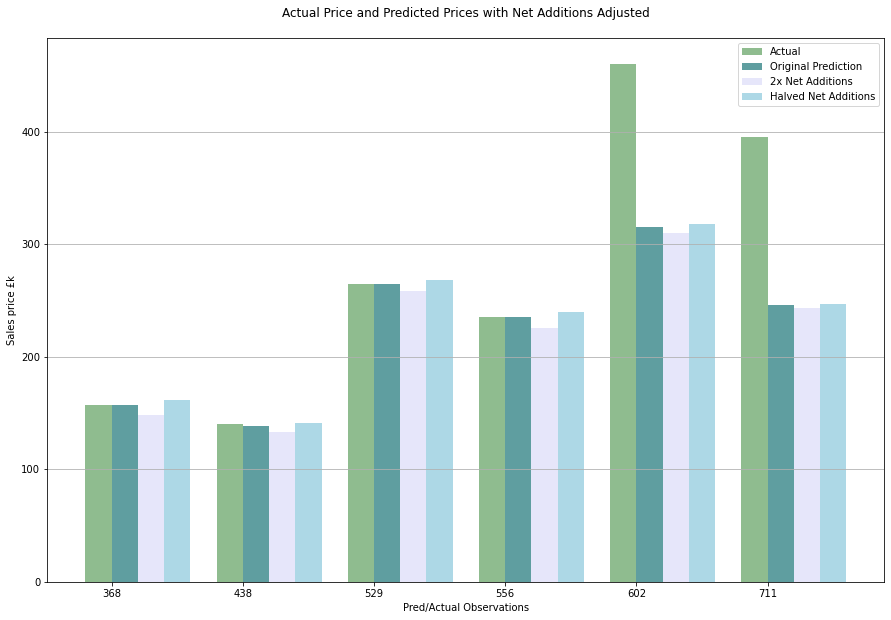

In [67]:
plt.figure(figsize=(15,10))
n=1
t=4
d=6
w=0.8
x_1 = [t*element +w*n for element in range(d)]
bar1 = plt.bar(x_1,results_df.actual, color = 'darkseagreen',linewidth = 0.4)
n=2
x_2 = [t*element +w*n for element in range(d)]
bar2 = plt.bar(x_2,results_df.pred, color = 'cadetblue')
n=3
x_3 = [t*element +w*n for element in range(d)]
bar3 = plt.bar(x_3,results_df.d_pred,color = 'lavender')
n=4
x_4 = [t*element +w*n for element in range(d)]
bar4 = plt.bar(x_4,results_df.h_pred,color = 'lightblue')
 
plt.xlabel('Pred/Actual Observations')
plt.ylabel('Sales price £k')
plt.legend((bar1,bar2,bar3,bar4),('Actual', 'Original Prediction', '2x Net Additions', 'Halved Net Additions'))
plt.title('Actual Price and Predicted Prices with Net Additions Adjusted\n')
ax = plt.subplot()
ax.set_xticks((np.array(x_1)+np.array(x_2))/2)
ax.set_xticklabels(results_df.obs_ref)
plt.grid(axis = 'y')
plt.show()

In [68]:
results_df.to_csv('mod_e__dummy_output.csv')
results_df['h_vs_pred'] = (results_df['h_pred']-results_df['pred'])/results_df['h_pred']*100
results_df['d_vs_pred'] = (results_df['d_pred']-results_df['pred'])/results_df['d_pred']*100
#results_df

In [69]:
pred_diffs = pd.DataFrame(results_df[['obs_ref','h_vs_pred','d_vs_pred']])
pred_diffs = pred_diffs.melt(id_vars = 'obs_ref')
pred_diffs

,obs_ref,variable,value
0,368,h_vs_pred,2.896
1,438,h_vs_pred,1.899
2,529,h_vs_pred,1.188
3,556,h_vs_pred,2.016
4,602,h_vs_pred,0.834
5,711,h_vs_pred,0.409
6,368,d_vs_pred,-6.350
7,438,d_vs_pred,-3.874
8,529,d_vs_pred,-2.473
9,556,d_vs_pred,-4.292


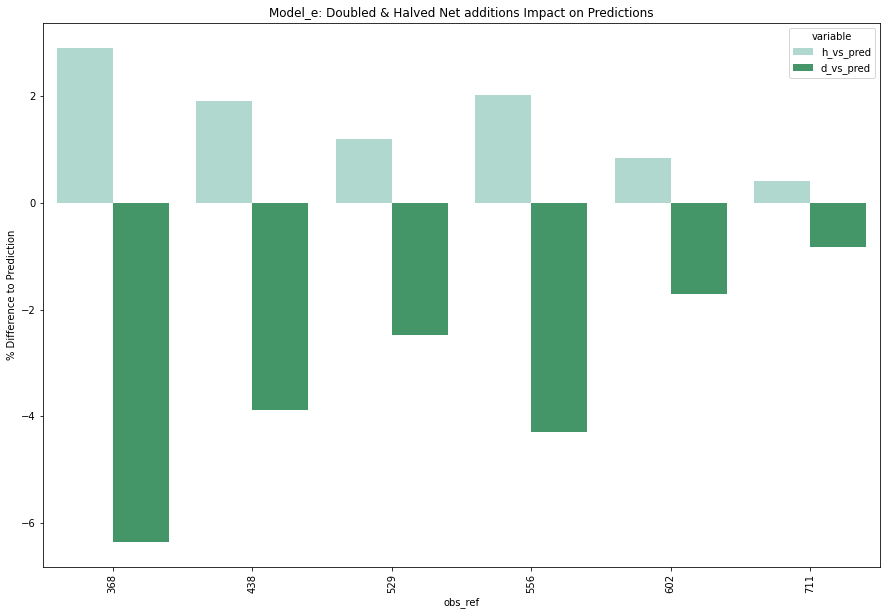

In [70]:
plt.figure(figsize=(15,10))
sns.barplot(x = 'obs_ref', y = 'value', hue = 'variable', data = pred_diffs, palette ='BuGn')
plt.xticks(rotation=90)
plt.ylabel('% Difference to Prediction')
plt.title('Model_e: Doubled & Halved Net additions Impact on Predictions')
plt.show()

### On Model_a - Dummy set

In [53]:
dummy_d_a = pd.read_csv('mod_a_dummy.csv')
dummy_d_a = dummy_d_a.rename(columns = {'Unnamed: 0': 'ref'})
dummy_d_a= dummy_d_a.set_index('ref')
dummy_d_a.head(10)

,la_code,la_name,year,g_belt_area,total_area,rpi,int_rate_max,int_rate_min,median_income,population,num_hh_1dp,num_hh_>2dp,num_hh_2dp,num_hh_1f,num_hh_1m,num_hh_oth,num_hh_tot,gdp,dwell_stock,net_additions,num_wait_lst,aff_own,aff_rent,aff_int_rent,aff_lon_rent,aff_sh_own,aff_soc_rent,pop_density,avail_land,g_belt_percent,pop_density_avail,ratio_new_exist_prices,ratio_new_existing_num,wait_list_to_hh,net_add_to_hh,gdp_hh,avg_hh_size,prop_det_sls,prop_semi_sls,prop_terr_sls,prop_flat_sls,prop_hh_1_person,prop_hh_dp,all_sls_price
ref,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92,E07000200,Babergh,2019,0,59510,288.8,0.75,0.75,25755,92036,4154.308,1540.283,3953.871,6807.479,5216.942,18664.351,40337.235,2143,3433,1158,912,6,20,0,0,16,0,1.547,1.000,0.000,1.547,1.091,0.164,0.023,0.014,0.053,2.282,0.408,0.263,0.237,0.091,0.298,0.239,280.0
178,E07000068,Brentwood,2019,13730,15310,288.8,0.75,0.75,33040,77021,4096.267,1135.116,3900.577,5223.890,4072.604,13085.177,31513.631,3994,2496,422,560,0,17,0,0,18,0,5.031,0.103,0.897,48.747,0.639,0.162,0.018,0.007,0.127,2.444,0.249,0.270,0.166,0.316,0.295,0.290,405.5
287,E06000014,York,2018,22410,27190,281.6,0.75,0.75,26506,209893,10941.575,2638.673,7689.279,14236.205,12367.895,39065.776,86939.403,7069,7617,2592,1161,5,19,0,0,9,36,7.719,0.176,0.824,43.911,1.188,0.065,0.013,0.015,0.081,2.414,0.205,0.316,0.306,0.172,0.306,0.245,235.0
368,E06000057,Northumberland,2016,43570,503220,263.1,0.25,0.25,25177,317444,17130.250,4739.871,12997.587,24203.711,19345.717,62700.447,141117.584,5889,8476,1982,8367,26,170,0,0,6,25,0.631,0.913,0.087,0.691,1.378,0.168,0.059,0.007,0.042,2.249,0.330,0.280,0.303,0.087,0.309,0.247,157.5
566,E08000005,Rochdale,2005,9930,15810,192.0,4.50,4.50,19567,207200,12086.959,5528.839,9815.455,14161.935,12143.649,30440.845,84177.683,3027,14960,266,5438,16,0,0,0,0,19,13.106,0.372,0.628,35.238,1.489,0.046,0.065,0.002,0.036,2.461,0.126,0.303,0.531,0.040,0.313,0.326,94.0
599,E07000091,New Forest,2021,4970,75220,305.0,0.25,0.25,30587,175800,8574.853,2256.800,7121.015,14235.595,10146.705,37853.987,80188.954,5384,5142,844,1283,18,48,0,0,12,33,2.337,0.934,0.066,2.502,1.086,0.033,0.016,0.005,0.067,2.192,0.478,0.206,0.177,0.139,0.304,0.224,380.0
699,E07000211,Reigate and Banstead,2020,8770,12910,293.1,0.25,0.10,34935,149243,8139.611,2404.600,8137.446,8810.874,7020.419,24969.430,59482.380,6223,9,918,884,0,23,0,0,30,52,11.560,0.321,0.679,36.049,1.169,0.102,0.015,0.008,0.105,2.509,0.276,0.283,0.171,0.270,0.266,0.314,425.0


In [54]:
dummy_d_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 92 to 699
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   la_code                 7 non-null      object 
 1   la_name                 7 non-null      object 
 2   year                    7 non-null      int64  
 3   g_belt_area             7 non-null      int64  
 4   total_area              7 non-null      int64  
 5   rpi                     7 non-null      float64
 6   int_rate_max            7 non-null      float64
 7   int_rate_min            7 non-null      float64
 8   median_income           7 non-null      int64  
 9   population              7 non-null      int64  
 10  num_hh_1dp              7 non-null      float64
 11  num_hh_>2dp             7 non-null      float64
 12  num_hh_2dp              7 non-null      float64
 13  num_hh_1f               7 non-null      float64
 14  num_hh_1m               7 non-null      flo

In [55]:
#Split target and scale
X_dum_a = dummy_d_a.iloc[ : , 2:43]
y_dum_a = dummy_d_a.iloc[ : , -1]

X_dum_a = scaler.transform(X_dum_a)

In [56]:
# Get predictions from model b - will look odd. 
score_dummy_a = nn_model_b.evaluate(X_dum_a,y_dum_a)
score_dummy_a

1/1 [==============================] - 0s 47ms/step - loss: 37.3199 - mse: 4595.1104


[37.31992721557617, 4595.1103515625]

In [57]:
model_perf(nn_model_b, X_dum_a,y_dum_a)


R2:: 0.67%
MSE:  4595.111
MAE:  37.32
RMSE:  67.787
Percentage difference:: 13.21%
Max £ difference:  149.728

Median £ difference:  4.727
Median actual price: 280.0  Median pedicted price: 275.273

Number of predictions over 10% wrong:  2 out of  7
Number of predictions 10% wrong pr less:  5 out of  7


,actual,pred,diff,percent_diff
0,280.0,275.273,4.727,1.688
1,405.5,503.967,98.467,24.283
2,235.0,230.167,4.833,2.056
3,157.5,159.407,1.907,1.211
4,94.0,94.119,0.119,0.127
5,380.0,378.542,1.458,0.384
6,425.0,574.728,149.728,35.230


In [59]:
### now on the set with halved net addtions.
dummy_h_a = pd.read_csv('mod_a_dummy_half.csv')
dummy_h_a = dummy_h_a.rename(columns = {'Unnamed: 0': 'ref'})
dummy_h_a= dummy_h_a.set_index('ref')
dummy_h_a.head(10)

,la_code,la_name,year,g_belt_area,total_area,rpi,int_rate_max,int_rate_min,median_income,population,num_hh_1dp,num_hh_>2dp,num_hh_2dp,num_hh_1f,num_hh_1m,num_hh_oth,num_hh_tot,gdp,dwell_stock,net_additions,num_wait_lst,aff_own,aff_rent,aff_int_rent,aff_lon_rent,aff_sh_own,aff_soc_rent,pop_density,avail_land,g_belt_percent,pop_density_avail,ratio_new_exist_prices,ratio_new_existing_num,wait_list_to_hh,net_add_to_hh,gdp_hh,avg_hh_size,prop_det_sls,prop_semi_sls,prop_terr_sls,prop_flat_sls,prop_hh_1_person,prop_hh_dp,all_sls_price
ref,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92,E07000200,Babergh,2019,0,59510,288.8,0.75,0.75,25755,92036,4154.308,1540.283,3953.871,6807.479,5216.942,18664.351,40337.235,2143,3433,289.5,912,6,20,0,0,16,0,1.547,1.000,0.000,1.547,1.091,0.164,0.023,0.014,0.053,2.282,0.408,0.263,0.237,0.091,0.298,0.239,280.0
178,E07000068,Brentwood,2019,13730,15310,288.8,0.75,0.75,33040,77021,4096.267,1135.116,3900.577,5223.890,4072.604,13085.177,31513.631,3994,2496,105.5,560,0,17,0,0,18,0,5.031,0.103,0.897,48.747,0.639,0.162,0.018,0.007,0.127,2.444,0.249,0.270,0.166,0.316,0.295,0.290,405.5
287,E06000014,York,2018,22410,27190,281.6,0.75,0.75,26506,209893,10941.575,2638.673,7689.279,14236.205,12367.895,39065.776,86939.403,7069,7617,648.0,1161,5,19,0,0,9,36,7.719,0.176,0.824,43.911,1.188,0.065,0.013,0.015,0.081,2.414,0.205,0.316,0.306,0.172,0.306,0.245,235.0
368,E06000057,Northumberland,2016,43570,503220,263.1,0.25,0.25,25177,317444,17130.250,4739.871,12997.587,24203.711,19345.717,62700.447,141117.584,5889,8476,495.5,8367,26,170,0,0,6,25,0.631,0.913,0.087,0.691,1.378,0.168,0.059,0.007,0.042,2.249,0.330,0.280,0.303,0.087,0.309,0.247,157.5
566,E08000005,Rochdale,2005,9930,15810,192.0,4.50,4.50,19567,207200,12086.959,5528.839,9815.455,14161.935,12143.649,30440.845,84177.683,3027,14960,66.5,5438,16,0,0,0,0,19,13.106,0.372,0.628,35.238,1.489,0.046,0.065,0.002,0.036,2.461,0.126,0.303,0.531,0.040,0.313,0.326,94.0
599,E07000091,New Forest,2021,4970,75220,305.0,0.25,0.25,30587,175800,8574.853,2256.800,7121.015,14235.595,10146.705,37853.987,80188.954,5384,5142,211.0,1283,18,48,0,0,12,33,2.337,0.934,0.066,2.502,1.086,0.033,0.016,0.005,0.067,2.192,0.478,0.206,0.177,0.139,0.304,0.224,380.0
699,E07000211,Reigate and Banstead,2020,8770,12910,293.1,0.25,0.10,34935,149243,8139.611,2404.600,8137.446,8810.874,7020.419,24969.430,59482.380,6223,9,229.5,884,0,23,0,0,30,52,11.560,0.321,0.679,36.049,1.169,0.102,0.015,0.008,0.105,2.509,0.276,0.283,0.171,0.270,0.266,0.314,425.0


In [60]:
#Split target and scale
X_dum_h_a = dummy_h_a.iloc[ : , 2:43]
y_dum_h_a = dummy_h_a.iloc[ : , -1]

X_dum_h_a = scaler.transform(X_dum_h_a)

In [61]:
# Get predictions from model b - will look odd. 
score_dummy_a_h = nn_model_b.evaluate(X_dum_h_a,y_dum_h_a)
score_dummy_a_h

1/1 [==============================] - 0s 59ms/step - loss: 38.1738 - mse: 5006.1245


[38.17379379272461, 5006.12451171875]

In [62]:
model_perf(nn_model_b, X_dum_h_a,y_dum_h_a)


R2:: 0.64%
MSE:  5006.125
MAE:  38.174
RMSE:  70.754
Percentage difference:: 13.52%
Max £ difference:  154.852

Median £ difference:  2.227
Median actual price: 280.0  Median pedicted price: 282.227

Number of predictions over 10% wrong:  2 out of  7
Number of predictions 10% wrong pr less:  5 out of  7


,actual,pred,diff,percent_diff
0,280.0,282.227,2.227,0.795
1,405.5,510.613,105.113,25.922
2,235.0,237.698,2.698,1.148
3,157.5,156.228,1.272,0.808
4,94.0,93.924,0.076,0.081
5,380.0,380.978,0.978,0.257
6,425.0,579.852,154.852,36.436


In [66]:
a_d_d = pd.DataFrame(model_perf(nn_model_b, X_dum_a,y_dum_a))
a_d_d.columns = ['actual', 'd_pred','d_diff', 'd_percent']
a_d_h = pd.DataFrame(model_perf(nn_model_b, X_dum_h_a,y_dum_h_a))
a_d_h.columns =  ['actual', 'h_pred','h_diff', 'h_percent']
results_df_a = a_d_d.merge(a_d_h)


R2:: 0.67%
MSE:  4595.111
MAE:  37.32
RMSE:  67.787
Percentage difference:: 13.21%
Max £ difference:  149.728

Median £ difference:  4.727
Median actual price: 280.0  Median pedicted price: 275.273

Number of predictions over 10% wrong:  2 out of  7
Number of predictions 10% wrong pr less:  5 out of  7

R2:: 0.64%
MSE:  5006.125
MAE:  38.174
RMSE:  70.754
Percentage difference:: 13.52%
Max £ difference:  154.852

Median £ difference:  2.227
Median actual price: 280.0  Median pedicted price: 282.227

Number of predictions over 10% wrong:  2 out of  7
Number of predictions 10% wrong pr less:  5 out of  7


In [68]:
mod_a = pd.DataFrame(model_perf(nn_model_a, X_test, y_test))
mod_a = mod_a.iloc[[92,178,287,368,566,599,699]].reset_index(drop = True)
mod_a


R2:: 0.92%
MSE:  535.177
MAE:  15.392
RMSE:  23.134
Percentage difference:: 8.02%
Max £ difference:  170.437

Median £ difference:  10.581
Median actual price: 171.95  Median pedicted price: 167.374

Number of predictions over 10% wrong:  235 out of  859
Number of predictions 10% wrong pr less:  624 out of  859


,actual,pred,diff,percent_diff
0,280.0,255.273,24.727,8.831
1,405.5,474.013,68.513,16.896
2,235.0,241.949,6.949,2.957
3,157.5,147.104,10.396,6.601
4,94.0,80.193,13.807,14.688
5,380.0,345.577,34.423,9.059
6,425.0,467.366,42.366,9.969


In [69]:
results_df_a = results_df_a.merge(mod_a)
results_df_a = results_df_a.drop(columns = ['d_diff', 'd_percent', 'h_diff', 'h_percent', 'diff', 'percent_diff'])
results_df_a['obs_ref'] = ['92','178','287','368','566','599','699']
results_df_a.insert(0,'obs_ref',results_df_a.pop('obs_ref'))
results_df_a

,obs_ref,actual,d_pred,h_pred,pred
0,92,280.0,275.273,282.227,255.273
1,178,405.5,503.967,510.613,474.013
2,287,235.0,230.167,237.698,241.949
3,368,157.5,159.407,156.228,147.104
4,566,94.0,94.119,93.924,80.193
5,599,380.0,378.542,380.978,345.577
6,699,425.0,574.728,579.852,467.366


In [70]:
results_df_a.to_csv('mod_a_dummy_output.csv')
results_df_a['h_vs_pred'] = (results_df_a['h_pred']-results_df_a['pred'])/results_df_a['h_pred']*100
results_df_a['d_vs_pred'] = (results_df_a['d_pred']-results_df_a['pred'])/results_df_a['d_pred']*100
#results_df_a
pred_diffs_a = pd.DataFrame(results_df_a[['obs_ref','h_vs_pred','d_vs_pred']])
pred_diffs_a = pred_diffs_a.melt(id_vars = 'obs_ref')
pred_diffs_a

,obs_ref,variable,value
0,92,h_vs_pred,9.550
1,178,h_vs_pred,7.168
2,287,h_vs_pred,-1.788
3,368,h_vs_pred,5.840
4,566,h_vs_pred,14.618
5,599,h_vs_pred,9.292
6,699,h_vs_pred,19.399
7,92,d_vs_pred,7.265
8,178,d_vs_pred,5.944
9,287,d_vs_pred,-5.119


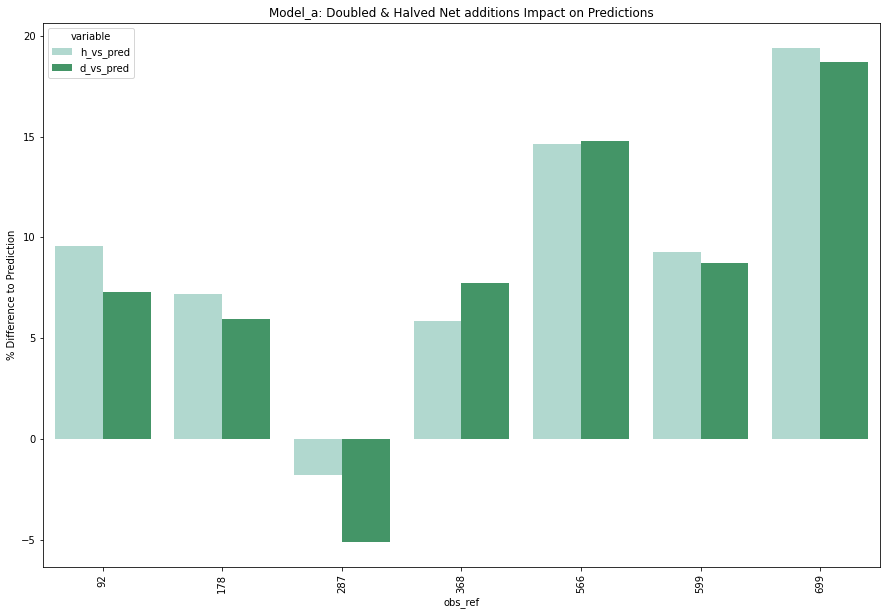

In [71]:
plt.figure(figsize=(15,10))
sns.barplot(x = 'obs_ref', y = 'value', hue = 'variable', data = pred_diffs_a, palette ='BuGn')
plt.xticks(rotation=90)
plt.ylabel('% Difference to Prediction')
plt.title('Model_a: Doubled & Halved Net additions Impact on Predictions')
plt.show()

In [72]:
results_df_a

,obs_ref,actual,d_pred,h_pred,pred,h_vs_pred,d_vs_pred
0,92,280.0,275.273,282.227,255.273,9.550,7.265
1,178,405.5,503.967,510.613,474.013,7.168,5.944
2,287,235.0,230.167,237.698,241.949,-1.788,-5.119
3,368,157.5,159.407,156.228,147.104,5.840,7.718
4,566,94.0,94.119,93.924,80.193,14.618,14.796
5,599,380.0,378.542,380.978,345.577,9.292,8.708
6,699,425.0,574.728,579.852,467.366,19.399,18.680
